# SEM TEXT ANALYSIS

### Import Packages

In [16]:
# DATA PROCCESSING
import pandas as pd # Matrix Operations
import numpy as np # Linear Algebra
import os # OS Functions

# GRAPHING
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.patches as mpatches
import seaborn as sns
import seaborn.objects as so
# %matplotlib inline

# MACHINE LEARNING
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN, SpectralClustering, OPTICS
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import manifold


# NATURAL LANGUAGE PROCCESSING (NLP)
import gensim
import gensim.downloader as api
from gensim.models import *
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# MISC
import distinctipy # Generate n colors
import re # Regex
import random # Random Operations
import string # String operators
from itertools import chain
import warnings # Control warnings output
warnings.filterwarnings("ignore")
from copy import deepcopy # Making copies of classes
import pickle # Saving and loading models
from typing import * # Type hinting

# LOCATION-BASED
from sklearn.metrics.pairwise import haversine_distances # Distance around Earth's curvature
from math import radians, isnan
import requests # HTTP requests
from bs4 import BeautifulSoup # HTML Parser
import pgeocode # Zipcode to Coordinates
import time
import logging
from requests.adapters import HTTPAdapter, Retry

class COLOR:
    """Class for displaying colored text in console outputs
    
    Use 'COLOR.<color>' in print statement before text.
    """
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    LIGHT_PURPLE = '\033[35m'
    LIGHT_CYAN = '\033[36m'
    LIGHT_BLUE = '\033[34m'
    LIGHT_GREEN = '\033[32m'
    LIGHT_YELLOW = '\033[33m'
    LIGHT_RED = '\033[31m'
    BOLD = '\033[1m'
    BOLD_OFF = '\033[21m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'


def get_geodesic_info(zips: list = None) -> int:
    nomi = pgeocode.Nominatim('us') # Use United States Zip Codes
    zips = [str(zip) for zip in zips]
    # Extract Information
    return(pd.DataFrame(nomi.query_postal_code(zips)).drop(columns=['county_code', 'community_name', 'community_code', 'accuracy']))

def extract_postal_code(string: str = None):
    string = ' '.join(string.split()) # Replace trailing whitespace
    code = re.search(r'\s?[A-Z]{2}\s(\d{5})(-\d{4})?', string) # Search for Zipcode
    if code is None:
        return(np.nan)
    return(code.group(1))

def lookup_park_address_info(unitCodes: list = None) -> pd.DataFrame():
    logging.basicConfig(level=logging.DEBUG)
    session = requests.Session() # Start Session
    retries = Retry(total=5, backoff_factor=1, status_forcelist=[ 502, 503, 504 ]) # Setup retry succesion
    session.mount('http://', HTTPAdapter(max_retries=retries))
    logging.getLogger("urllib3").setLevel(logging.WARNING) # Disable console logs
    address_book = [] # List to store address information
    for code in unitCodes:
        code = code.replace(' ', '') # Remove any whitespace
        if code == "NCPC": # If park is NCPC, use NAMA's address
            url = "https://www.nps.gov/" + "NAMA" + "/contacts.htm"
        else:
            url = "https://www.nps.gov/" + code + "/contacts.htm"
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
        response = session.get(url,headers=headers)
        soup = BeautifulSoup(response.content, 'html') # Extract HTML
        soup = soup.find('div', attrs = {'class':'mailing-address'}) # Find Mailing Address Information
        address = soup.find('p', attrs = {'class':'adr'}).text # Grab the Address
        address = ' '.join(address.split()) # Remove unnessesary whitespace
        zipcode = extract_postal_code(address) # Grab the ZipCode
        address_book.append([code, address, zipcode]) # Add to Addressbook
    address_book = pd.DataFrame(address_book, columns=['unit_code', 'address', 'zip_code']) # Convert to DataFrame
    address_book = address_book.join(get_geodesic_info(address_book['zip_code'])).drop(columns=['postal_code']) # Grab Geodesic Information
    return(address_book)

def compute_haversine_distance(p_lat: float = None, p_lon: float = None, u_lat: float = None, u_lon: float = None) -> float:
    """ Return dista
    
    Parameters:
    
    Returns:
    (float): Distance in miles between the two coordinates
    """
    if isnan(p_lat) or isnan(p_lon) or isnan(u_lat) or isnan(u_lon):
        return(np.nan)
    geodesic_info = pd.DataFrame([[p_lat, p_lon], [u_lat, u_lon]])
    geodesic_info = geodesic_info.applymap(radians) # Convert to Radians
    # Calculate and Extract Haversine Distance
    distance = haversine_distances([geodesic_info.iloc[0,:].values, geodesic_info.iloc[1,:].values])[0][1]
    distance = distance * 3958.75587 # Multiply by Earth radius to convert to miles
    return(distance)

def clean_data(data: pd.DataFrame = None) -> pd.DataFrame:
    """Clean SEM data from rows and columns that are un-needed for analysis.

    Parameters:
    data (DataFrame): Data to be cleaned.

    Returns:
    (DataFrame): Cleaned DataFrame.
    """
    if (data is None): # Ensure paramters are specified
        print("ERROR: Specify DataFrame.")

    # Filtering Data to ensure they accepted the survey and they are eligible
    data = data[(data['s_eligible'] == "1") & (data['s_intro'] == "1")]
    # Drop columns: 's_eligible', 's_intro' and 4 other columns (That are all NRB Related)
    data = data.drop(columns=['s_eligible', 's_intro', 's_nrb', 's_nrb_residence', 's_nrb_us', 's_nrb_overnight', 's_datayear', 'o_eligible'])
    data = data.replace({'#NULL!':np.nan, None:np.nan}) # Converting #NULL!'s/None's to "NaN" datatype
    data = data.apply(pd.to_numeric, errors='ignore') # Convering column to numeric if possible
    data = data.reset_index(drop=True) # Resetting and droping the index column.
    return(data)

def clean_text(text: str, tokenizer: any, stopwords: set) -> list:
    """Clean text sentances from characters and words that are not needed to be vectorized.

    Parameters:
    text (str): sentence string to be cleaned.
    tokenizer (function): Tokenizer function to be used.
    stopwords (set): Set of stopwords to use.

    Returns:
    list: list of token words for each sentence
    """
    text = str(text).lower()  # Lowercase words
    text = re.sub(r"\[(.*?)\]", "", text)  # Remove [+XYZ chars] in content
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = re.sub(r"\w+…|…", "", text)  # Remove ellipsis (and last word)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)  # Replace dash between words
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)  # Remove punctuation

    tokens = tokenizer(text)  # Get tokens from text
    tokens = [t for t in tokens if not t in stopwords]  # Remove stopwords
    tokens = ["" if t.isdigit() else t for t in tokens]  # Remove digits
    tokens = [t for t in tokens if len(t) > 1]  # Remove short tokens
    return(tokens)

def vectorize(list_of_docs: np.array, model: gensim.models.keyedvectors.KeyedVectors, api_model: bool = False) -> list:
    """Generate vectors for list of documents using Word Embedding.

    Parameters:
    list_of_docs (Array): array of tokenized words.
    model (Gensim Model): model to generate vectors.
    api_model (bool)(default: False): Boolean to declare if the model is from an api.

    Returns:
    list: list of vector features.
    """
    features = [] # List of Features
    for tokens in list_of_docs: # For each set of tokens in the list of docs
        zero_vector = np.zeros(model.vector_size) # Initialize vector
        vectors = [] # List of Vectors
        for token in tokens: # For each token in sentence
            if api_model: # If the model is an api model (different syntax required)
                if token in model: # Only add tokens that are known to the wv model to the vector list
                    try:
                        vectors.append(model[token])
                    except KeyError:
                        continue
            else: # Otherwise the model is trained by us (different syntax required)
                if token in model.wv: # Only add tokens that are known to the wv model to the vector list
                    try:
                        vectors.append(model.wv[token])
                    except KeyError:
                        continue
        if vectors: # If the List is not empty
            vectors = np.asarray(vectors) # Convert to Array
            avg_vec = vectors.mean(axis=0) # Calculate Mean
            features.append(avg_vec) # Add to Features
        else:
            features.append(zero_vector) # Otherwise add empty vector to Features
    return(features)

def set_all_seeds(seed: int = 42, echo: bool = True) -> None:
    """Function to set all seeds for reproducibility.

    Parameters:
    seed (int)(default: 42): Integer to set the seeds to.
    echo (bool)(default: True): Boolean to declare if function can output to console.
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    if echo:
        print(COLOR.GREEN, "Seeds have been reset to: ", COLOR.BOLD, seed, COLOR.END, sep='')

def get_text_columns(data: pd.DataFrame) -> list:
    """Get list of all string columns from SEM dataset

    Parameters:
    data (DataFrame): Dataframe to check columns

    Returns:
    list: list of all column headers that start with 'o' (i.e text column)
    """
    return([x for x in data if x.startswith('o')]) #Columns that start with 'o'


class NLP():
    """Class to hold information, data and function for Natural Language Proccessing(NLP) clusters.
    

    """
    def __init__(self, data: pd.Series, embedding_model: gensim.models.keyedvectors.KeyedVectors = None, echo: bool = True, reset_seeds: bool = True, model_name: string = None) -> Any:
        """ NLP class to hold cluster information/data

        Parameters:
        data (DataFrame Column): data to be analyzed.
        model (Gensim model): model to be used for NLP.
        echo (bool)(default: True): Boolean to declare if function can output to console.
        reset_seeds (bool)(default: True): Boolean to declare if set_all_seeds() function is called.

        Returns:
        object to hold information/data on the NLP cluster.

        Available Functions:

        dimension_reduce()
        
        clusterize()

        get_sil_values()

        get_cluster_labels()

        get_cluster_info()

        get_clusters()

        generate_cluster_graph_mpl()

        generate_cluster_graph()
        """
        if model_name is None:
            print(COLOR.RED, 'ERROR: No model_name.', COLOR.END, sep='')
            return(None)
        self.model_name = model_name
        self.data = data # Storing data into class
        # Booleans to keep track of what operations have been done for helper functions
        self.vectorized = False
        self.dim_reduced = False
        self.clustered = False
        # print(data.name)
        if reset_seeds: # Reset seeds for reproducibility
            set_all_seeds(echo=echo)
            
        # Cleaning Data
        temp_frame = pd.DataFrame(np.array(data.copy()), columns=['variable']) # Convert column to array, drop NaN's
        temp_frame = temp_frame[~temp_frame['variable'].isnull()] # Remove null rows
        self.indexi = temp_frame.index # Keep Track of index for future analysis
        if echo:
            print(len(temp_frame), 'total samples') # Log samples
        
        # Generate stopwords, tokens and vectors for NLP model
        custom_stopwords = set(stopwords.words("english")) # Declare stop words
        temp_frame['tokens'] = temp_frame['variable'].map(lambda x: clean_text(x, word_tokenize, custom_stopwords)) # Remove stopwords/uneeded characters
        self.docs = temp_frame['variable'].values # English type values for sentances
        self.tokenized_docs = temp_frame['tokens'].values # Creating tokenized values from english words
        
        # Creating the Model
        if embedding_model is None: # Create own model
            self.embedding_model = Word2Vec(sentences=self.tokenized_docs, vector_size=100, workers=1, seed=seed) # Feeding the tokenized values into the model
            self.vectorized_docs = vectorize(self.tokenized_docs, model=self.embedding_model) # Creating vectors for each doc
        else: # Use API model
            self.embedding_model = embedding_model
            self.vectorized_docs = vectorize(self.tokenized_docs, model=self.embedding_model, api_model=True)
        if echo:
            print('Successfully Tokenized')
        self.vectorized = True

    def dimension_reduce(self, dim_redu_algorithm: str = 'pca', echo: bool = True, reset_seeds: bool = True, perplexity: float = 30, early_exaggeration: float = 12, learing_rate: any = 'auto', n_iter: int = 1000) -> None:
        """Function to reduce n-dimensional vectors to 2-dimensions.

        Parameters:
        dim_redu_algorithm (str)(default: 'pca'): Algorithm to reduce dimensions (see list below).
        echo (bool)(default: True): Boolean to declare if function can output to console.
        reset_seeds (bool)(default: True): Boolean to declare if set_all_seeds() function is called.

        Returns:
        None

        Available dimension reduction algorithms:

        'pca': Principal Component Analysis

        'isomap': Non-Linear - Isometric Mapping

        'tsne': T-distributed Stochastic Neighbor Embedding

        'mds': Multidimensional Scaling

        'lle': Locally Linear Embedding

        'spectral_emb': Spectral Embedding
        """
        if not self.vectorized: # Ensure data has been vectorized before reduction
            print(COLOR.RED, 'ERROR: No tokens found.', COLOR.END, sep='')
            return
        if reset_seeds: # Reset Seeds
            set_all_seeds(echo=echo)
        self.dim_redu_algorithm = dim_redu_algorithm # Setting the algorithm
        # Dimensionality Reducution to reduce to 2-dimensions
        if self.dim_redu_algorithm == 'pca': # Principal Component Analysis (PCA)
            self.pca = PCA(n_components=2).fit(self.vectorized_docs)
            self.datapoints = self.pca.transform(self.vectorized_docs)
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        elif self.dim_redu_algorithm == 'isomap': # Non-Linear - Isometric Mapping (ISOMAP)
            self.iso = manifold.Isomap(n_neighbors=3, n_components=2).fit(self.vectorized_docs)
            self.datapoints = self.iso.transform(self.vectorized_docs)
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        elif self.dim_redu_algorithm == 'tsne': # T-distributed Stochastic Neighbor Embedding (TSNE)
            self.tsn = manifold.TSNE(n_components=2, perplexity=perplexity, early_exaggeration=early_exaggeration, learning_rate=learing_rate, n_iter=n_iter)
            self.datapoints = self.tsn.fit_transform(pd.DataFrame(self.vectorized_docs))
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        elif self.dim_redu_algorithm == 'mds': # Multidimensional Scaling (MDS)
            self.mds = manifold.MDS(n_components=2, max_iter=10, eps=1)
            self.datapoints = self.mds.fit_transform(pd.DataFrame(self.vectorized_docs))
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        elif self.dim_redu_algorithm == 'lle': # Locally Linear Embedding
            self.lle = manifold.LocallyLinearEmbedding(n_neighbors=5, n_components=2)
            self.datapoints = self.lle.fit_transform(pd.DataFrame(self.vectorized_docs))
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        elif self.dim_redu_algorithm == 'spectral_emb': # Spectral Embedding
            self.lle = manifold.SpectralEmbedding(n_components=2)
            self.datapoints = self.lle.fit_transform(pd.DataFrame(self.vectorized_docs))
            self.datapoints = pd.DataFrame(self.datapoints, columns=['component1', 'component2'])
        else:
            print(COLOR.RED, COLOR.BOLD, 'ERROR: ', self.dim_redu_algorithm, 'is not an available algorithm', COLOR.END)
            return
        self.datapoints['sentance'] = self.docs # Add the english sentances to the dataframe
        self.datapoints['orig_index'] = self.indexi # Add the original indexi to the dataframe for future analysis
        self.X = self.datapoints[['component1', 'component2']].to_numpy() # Convert X/Y components to self.X
        self.dim_reduced = True
        if echo:
            print(COLOR.LIGHT_BLUE, 'Reduced dimensions to 2 using ', COLOR.BLUE, COLOR.BOLD, self.dim_redu_algorithm.upper(), COLOR.END, sep='')
    
    def clusterize(self, cluster_algorithm: str = 'kmeans', num_clusters: int = 15, n_neighbors: int = 10, n_init: int = 10, gamma: float = 1.0, degree: float = 3, coef0: float = 1, echo: bool = True, reset_seeds: bool = True) -> None:
        """Apply Cluster Algorithms to group data.

        Parameters:
        cluster_algorithm (str)(default: 'kmeans'): Cluster Algorithm to use (see list below).
        num_clusters (int)(default: 15): Number of clusters to generate (does not apply to DBSCAN and OPTICS)
        echo (bool)(default: True): Boolean to declare if function can output to console.
        reset_seeds (bool)(default: True): Boolean to declare if set_all_seeds() function is called.

        Returns:
        None

        Available Cluster Algorithms to use:

        'kmeans': K-Means

        'kmeans_mb': MiniBatchK-Means

        'dbscan': Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

        'spectral_clustering': Spectral Clustering

        'optics': Ordering Points To Identify the Clustering Structure (OPTICS)

        """
        if not self.dim_reduced: # Ensure data has been reduced to 2-dimensions
            print(COLOR.RED, 'ERROR: Dimensions have not been reduced.', COLOR.END, sep='')
            return
        if reset_seeds: # Reset Seeds
            set_all_seeds(echo=echo)
        self.num_clusters = num_clusters # Setting number of clusters
        self.cluster_algorithm = cluster_algorithm # Setting cluster algorithm
        # KMEANS
        if (self.cluster_algorithm == 'kmeans'):
            self.km = KMeans(n_clusters=self.num_clusters).fit(self.X)
            self.ca = self.km
            self.datapoints['cluster'] = self.km.labels_
        # MINIBATCH_KMEANS
        elif (self.cluster_algorithm == 'kmeans_mb'):
            self.km = MiniBatchKMeans(n_clusters=self.num_clusters, batch_size=500, n_init='auto').fit(self.X)
            self.ca = self.km
            self.datapoints['cluster'] = self.km.labels_
        # DBSCAN
        elif (self.cluster_algorithm == 'dbscan'):
            self.db = DBSCAN(eps=0.01, min_samples=20).fit(self.X)
            self.ca = self.db
            self.num_clusters = len(set(self.db.labels_)) - (1 if -1 in self.db.labels_ else 0) # Number of clusters (not including -1, i.e samples that do not fit in a cluster)
            self.datapoints['cluster'] = self.db.labels_
        # SPECTRAL CLUSTERING
        elif (self.cluster_algorithm == 'spectral_clustering'):
            self.sc = SpectralClustering(n_clusters=self.num_clusters, n_neighbors=n_neighbors, n_init=n_init, gamma=gamma, degree=degree, coef0=coef0).fit(self.X)
            self.ca = self.sc
            self.datapoints['cluster'] = self.sc.labels_
        # OPTICS
        elif (self.cluster_algorithm == 'optics'):
            self.op = OPTICS(min_samples=5).fit(self.X)
            self.ca = self.op
            self.datapoints['cluster'] = self.op.labels_
        else:
            print(COLOR.RED, COLOR.BOLD, 'ERROR: ', self.cluster_algorithm, ' is not an available algorithm', COLOR.END, sep='')
            return
        self.clustered = True
        if echo:
            print(COLOR.LIGHT_BLUE, 'Clustered using ', COLOR.BLUE, COLOR.BOLD, self.cluster_algorithm.upper(), COLOR.END, sep='')
            print(COLOR.YELLOW, "For n_clusters = ", str(self.num_clusters), COLOR.END, sep='')
            print(COLOR.YELLOW, COLOR.BOLD, f"Silhouette coefficient: {silhouette_score(self.X, self.ca.labels_):0.2f}", COLOR.END, sep='')
            try:
                print(COLOR.YELLOW, COLOR.BOLD, f"Inertia: {self.ca.inertia_:0.3f}", COLOR.END, sep='')
            except:
                pass
    def get_sil_values(self) -> None:
        """Print Silhouette Values for each cluster to console.

        Parameters:
        None

        Returns:
        None
        """
        if not self.clustered: # Ensure data has been clustered first
            print(COLOR.RED, 'ERROR: No Clusters found.', COLOR.END, sep='')
            return
        sample_silhouette_values = silhouette_samples(self.X, self.ca.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(self.num_clusters):
            cluster_silhouette_values = sample_silhouette_values[self.ca.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key=lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )

    def get_cluster_labels(self) -> list:
        """Get Cluster Labels
        
        Parameters:
        None

        Returns:
        list: List of clusters.
        """
        if not self.clustered: # Ensure data has been clustered first
            print(COLOR.RED, 'ERROR: No Clusters found.', COLOR.END, sep='')
            return
        return(list(np.unique(self.datapoints['cluster'])))

    def get_cluster_info(self, cluster: int = None) -> pd.DataFrame:
        """Get Cluster Information (components 1 and 2, sentence, orig_index, cluster, colorCode, alpha)
        
        Parameters:
        cluster (int): Number of cluster to get information for.

        Returns:
        DataFrame: Dataframe with cluster information
        """
        if not self.clustered:
            print(COLOR.RED, 'ERROR: No Clusters found.', COLOR.END, sep='')
            return
        if cluster is None:
            print(COLOR.RED, 'ERROR: No cluster number given.', COLOR.END, sep='')
            return
        return(self.datapoints[self.datapoints['cluster'] == cluster])

    def get_clusters(self, cluster_filter: list = None) -> pd.DataFrame:
        """Get Dataframe of cluster sentences split by cluster

        Parameters:
        cluster_filter (list)(default: all clusters): list of clusters to retrieve

        Returns:
        DataFrame: Dataframe of clusters(cols) with sentences for each cluster(rows)
        """
        if not self.clustered: # Ensure data has been clustered first
            print(COLOR.RED, 'ERROR: No Clusters found.', COLOR.END, sep='')
            return
        # Filter by Cluster
        if cluster_filter is None:
            cluster_filter = self.get_cluster_labels()

        df = pd.DataFrame()
        for clust in self.get_cluster_labels():
            if clust in cluster_filter:
                df = pd.concat([df, pd.DataFrame(self.get_cluster_info(clust)['sentance'].to_numpy(), columns=['cluster_' + str(clust)])], axis=1)
        return(df)

    def generate_cluster_graph_mpl(self, cluster_filter: list = None, figsize: tuple = (10, 10), num_annotations: int = 100, max_char_length: int = 20, hide_labels: bool = False, hide_legend: bool = False, echo = True, reset_seeds: bool = True) -> None:
        """Visualize Clusters using matplotlib
        Parameters:
        cluster_filter (list)(default: all clusters): List of clusters to display.
        figsize (tuple)(default: (10, 10)): X and Y size for plot.
        num_annotations (int)(default: 100): Number of random text sentence annotations to display.
        max_char_length (int)(default: 20): Limit of characters for a random sentence to be annotated.
        hide_labels: (bool)(default: False): Boolean to declare whether the annotations are hidden or not.
        hide_legend: (bool)(default: False): Boolean to declare whether the legend is hidden or not.
        echo (bool)(default: True): Boolean to declare if function can output to console.
        reset_seeds (bool)(default: True): Boolean to declare if set_all_seeds() function is called.

        Returns:
        None (Except for Plot Display)
        """
        # Declaring Figsize
        if not self.clustered: # Ensure data has been clustered first
            print(COLOR.RED, 'ERROR: No Clusters found.', COLOR.END, sep='')
            return
        if reset_seeds: # Reset Seeds
            set_all_seeds(echo=echo)
        plt.figure(figsize=figsize, dpi=100)

        # Declaring Colors based on Clusters
        color_list = distinctipy.get_colors(self.num_clusters)
        # self.datapoints['colorCode'] = [color_list[x] for x in self.datapoints['cluster']]
        self.datapoints['colorCode'] = [(0,0,0) if x == -1 else color_list[x] for x in self.datapoints['cluster']] # -1 only gets used for DBSCAN models (Makes unused points the Black cluster)
        self.datapoints['alpha'] = [0.05 if x == -1 else 0.3 for x in self.datapoints['cluster']] # -1 only gets used for DBSCAN models (Makes Black points more transparent)
        chart_data = self.datapoints.copy()
        
        # Filter by Cluster
        if cluster_filter is not None:
            chart_data = chart_data[chart_data['cluster'].isin(cluster_filter)]
        else:
            cluster_filter = self.get_cluster_labels()

        # Plot datapoints with associated colors/alphas
        plt.scatter(chart_data['component1'], chart_data['component2'], s=50, color=chart_data['colorCode'], alpha=chart_data['alpha'], edgecolors='none')
        # Setting X/Y Labels
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")

        # Display Legend
        if ~hide_legend:
            patchList = []
            for i, color in enumerate(color_list):
                if i in cluster_filter:
                    data_key = mpatches.Patch(color=color, label='Cluster ' + str(i))
                    patchList.append(data_key)
            plt.legend(handles=patchList, title='Cluster')
        
        # Display random labels
        if ~hide_labels:
            num_annotated = 0
            sent_nums = np.random.choice(range(len(chart_data)), len(chart_data), replace=False)
            for ind in sent_nums:
                # Ensures we only annotate x amount of labels
                if (num_annotated == num_annotations):
                    break
                # Grab Random Point
                # Ensuring Sentance is less than specified length for readability
                if (len(chart_data.iloc[ind]['sentance']) <= max_char_length):
                    plt.annotate(chart_data.iloc[ind]['sentance'], (chart_data.iloc[ind]['component1'], chart_data.iloc[ind]['component2']), size = 7, weight='bold')
                    num_annotated += 1
            print("Annotated", num_annotated, "Sentences")
            if (num_annotated < num_annotations):
                print("WARNING: Only", num_annotated, "Sentences from the data had character lengths under a max_char_length of", max_char_length)
        # Set Plot Title and Display
        plt.title('dim_redu_alg: ' + self.dim_redu_algorithm.upper() + ' clust_alg: ' + self.cluster_algorithm.upper() + ' ' + str(self.num_clusters) + ' clusters')
        plt.show()

    def generate_cluster_graph(self, cluster_filter: list = None, figsize: tuple = (10, 10), num_annotations: int = 100, max_char_length: int = 20, hide_labels: bool = False, hide_legend: bool = False, echo = True, reset_seeds: bool = True, jitter: bool = True, jitter_amount: float = 0.01) -> None:
        """Visualize Clusters using seaborne
        Parameters:
        cluster_filter (list)(default: all clusters): List of clusters to display.
        figsize (tuple)(default: (10, 10)): X and Y size for plot.
        num_annotations (int)(default: 100): Number of random text sentence annotations to display.
        max_char_length (int)(default: 20): Limit of characters for a random sentence to be annotated.
        hide_labels: (bool)(default: False): Boolean to declare whether the annotations are hidden or not.
        hide_legend: (bool)(default: False): Boolean to declare whether the legend is hidden or not.
        echo (bool)(default: True): Boolean to declare if function can output to console.
        reset_seeds (bool)(default: True): Boolean to declare if set_all_seeds() function is called.
        jitter (bool)(default: True): Boolean to declare if the points are jittered for better readability.

        Returns:
        None (Except for Plot Display)
        """
        if not self.clustered: # Ensure data has been clustered first
            print(COLOR.RED, COLOR.BOLD, 'ERROR: No Clusters found.', COLOR.END, sep='')
            return
        if reset_seeds: # Reset Seeds
            set_all_seeds(echo=echo)
        plt.figure(figsize=figsize, dpi=100)

        # Declaring Colors based on Clusters
        color_list = distinctipy.get_colors(self.num_clusters)
        # self.datapoints['colorCode'] = [color_list[x] for x in self.datapoints['cluster']]
        self.datapoints['colorCode'] = [(0,0,0) if x == -1 else color_list[x] for x in self.datapoints['cluster']] # -1 only gets used for DBSCAN models (Makes unused points the Black cluster)
        self.datapoints['alpha'] = [0.05 if x == -1 else 0.3 for x in self.datapoints['cluster']] # -1 only gets used for DBSCAN models (Makes Black points more transparent)
        chart_data = self.datapoints.copy()
        if jitter:
            chart_data.component1 = chart_data.component1 + np.random.normal(jitter_amount, jitter_amount, chart_data.component1.shape)
            chart_data.component2 = chart_data.component2 + np.random.normal(jitter_amount, jitter_amount, chart_data.component1.shape)
        # Filter by Cluster
        if cluster_filter is not None:
            chart_data = chart_data[chart_data['cluster'].isin(cluster_filter)]
        else:
            cluster_filter = self.get_cluster_labels()
        
        f, ax = plt.subplots(figsize=figsize)
        sns.set_style('white')
        sns.scatterplot(data=chart_data, x=chart_data.component1, y=chart_data.component2, hue='cluster', palette=color_list, alpha=self.datapoints['alpha'], edgecolor = None)
        # sns.scatterplot(data=chart_data, x=jitter(chart_data.component1, 0.01), y=jitter(chart_data.component2, 0.01), hue='cluster', palette=color_list, alpha=self.datapoints['alpha'], edgecolor = None)
        plt.xlabel("Component 1")
        plt.ylabel("Component 2")
        plt.legend(title='Cluster')
        plt.title('model_name: ' + self.model_name.upper() + ' dim_redu_alg: ' + self.dim_redu_algorithm.upper() + ' clust_alg: ' + self.cluster_algorithm.upper() + ' ' + str(self.num_clusters) + ' clusters')
        # Display rabdom labels
        if not hide_labels:
            num_annotated = 0
            sent_nums = np.random.choice(range(len(chart_data)), len(chart_data), replace=False)
            for ind in sent_nums:
                # Ensures we only annotate x amount of labels
                if (num_annotated == num_annotations):
                    break
                # Grab Random Point
                # Ensuring Sentance is less than specified length for readability
                if (len(chart_data.iloc[ind]['sentance']) <= max_char_length):
                    plt.text(chart_data.iloc[ind]['component1'], chart_data.iloc[ind]['component2'], chart_data.iloc[ind]['sentance'], size = 7, weight='bold')
                    num_annotated += 1
            print("Annotated", num_annotated, "Sentences")
            if (num_annotated < num_annotations):
                print("WARNING: Only", num_annotated, "Sentences from the data had character lengths under a max_char_length of", max_char_length)
        if hide_legend:
            plt.legend([],[], frameon=False)
        plt.show()

    """Output a frequency table for a set of values.

    Parameters:
    values (DataFrame Column): values 
    dropna (boolean)(default: False): Drop NAN values before frequency calculation.
    dec (int)(default: 3): Number of decimal places to round 'pct' column to.

    Returns:
    (pd.DataFrame): Frequency Table.
    """

def build_frequency_table(values: pd.Series, dropna: bool = False, dec: int = 3) -> pd.DataFrame:
    """AI is creating summary for build_frequency_table

    Args:
        values (pd.Series): [description]
        dropna (bool, optional): [description]. Defaults to False.
        dec (int, optional): [description]. Defaults to 3.

    Returns:
        pd.DataFrame: [description]
    """
    df = pd.value_counts(values, dropna=dropna).to_frame().reset_index()
    df['pct'] = round(df['count'] / sum(df['count']), dec)
    return(df)

def translate_response_codes(values: pd.Series = None) -> pd.Series:
    if (values is None): # Ensure paramters are specified
        print("ERROR: Specify Series.")
    
    global data_ref1 # Dictionary Reference

    # Return unchanged values if the variable is not in the dictionary.
    if values.name not in data_ref1['variable'].to_list():
        return(values)
    ref_table = data_ref1[data_ref1['variable'] == values.name] # Grab the variable information that matches
    var_refs = ref_table[['value', 'value_label']].set_index('value')['value_label'].to_dict() # Convert to dict
    new_values = values.map(var_refs) # Replace values with dict values
    return(new_values)

def merge_model_data(models: list = None) -> pd.DataFrame:
    """ Merge information regarding multiple models suitable for Power BI import.

    Parameters:
    models (list): list containing NLP models to be merged.

    Returns:
    (pd.DataFrame): Merged data
    """
    merged_data = pd.DataFrame() # Initalizing merged DataFrame
    for model in models: # For each model
        data = model.datapoints.copy() # Copy the datapoint information
        data['model'] = model.model_name # Extract the name and place in a new column
        data['dim_redu_alg'] = model.dim_redu_algorithm
        data['clust_alg'] = model.cluster_algorithm
        merged_data = pd.concat([merged_data, data]).reset_index(drop=True) # Concat the data to the frame
    return(merged_data)

def save_dashboard_data(regen_park_geodata: bool = False) -> None:
    """Function to save the overall dataset into readable and survery data versions for Power BI to load
    """
    global data_clean # Importing the cleaned data
    global data_ref1 # Importing the data dictionary

    # Obtain the Readable Data
    readable_columns = list(set(data_clean.columns) & set(data_ref1['variable'])) # Readable columns are in the intersection with the data dictionary
    dashboard_data = data_clean.drop(columns=['weight_peak']).copy() # Drop un-needed column and copy data
    readable_dashboard_data = dashboard_data[readable_columns].apply(translate_response_codes, axis=0).copy() # Convert each column to the readable values from the dictionary
    readable_dashboard_data = readable_dashboard_data.join(readable_dashboard_data['s_npssite'].str.split(' - ', n=1, expand=True).rename(columns={0:'x_unitcode', 1:'x_parkname'})) # Extract the park unit code and park name
    print(COLOR.BOLD, 'Obtained readable data.', COLOR.END, sep='')

    # Rename the index columns to 'orig_index', this matches other dataframes used for relationships in Power BI
    dashboard_data = dashboard_data.reset_index().rename(columns={'index': 'orig_index'})
    readable_dashboard_data = readable_dashboard_data.reset_index().rename(columns={'index': 'orig_index'})

    # Obtain the geodesic park information and merging with readable data
    if regen_park_geodata:
        print(COLOR.GREEN, COLOR.BOLD, 'Regenerating geodesic data from parks in readable data', COLOR.END, sep='')
        geodesic_park_information = lookup_park_address_info(np.unique(readable_dashboard_data['x_unitcode'])[:])
        save_data(geodesic_park_information, 'unitcode_geoinformation')
    else:
        print(COLOR.BOLD, 'Pulling geodesic data from parks in readable data', COLOR.END, sep='')
        geodesic_park_information = pd.read_excel(r'C:\Users\alackey\OneDrive - DOI\Desktop\NPS Internship\SEM Text Analysis\Data\unitcode_geoinformation.xlsx', index_col=0)
    geodesic_park_information.columns = ["x_park_" + str(col) for col in geodesic_park_information.columns]
    readable_dashboard_data = readable_dashboard_data.join(geodesic_park_information.set_index('x_park_unit_code'), on='x_unitcode', validate='m:1')
    print(COLOR.BOLD, 'Added the parks geodesic data.', COLOR.END, sep='')

    # Obtain the geodesic user information and merging with readable data
    geodesic_user_information = get_geodesic_info(data_clean['n_zip_int'].astype("Int64"))
    geodesic_user_information.columns = ["x_user_" + str(col) for col in geodesic_user_information.columns]
    readable_dashboard_data = readable_dashboard_data.join(geodesic_user_information)
    print(COLOR.BOLD, 'Added the users geodesic data.', COLOR.END, sep='')

    # Calculate Distance Traveled
    readable_dashboard_data['x_distance_traveled'] = readable_dashboard_data[['x_park_latitude', 'x_park_longitude', 'x_user_latitude', 'x_user_longitude']].apply(lambda x: compute_haversine_distance(*x), axis=1)
    readable_dashboard_data['x_distance_traveled'] = readable_dashboard_data['x_distance_traveled'].astype("Float64")
    print(COLOR.BOLD, 'Saving data...', COLOR.END, sep='')
    # Save the Data as two seperate sheets in the same excel file
    with pd.ExcelWriter(path = r'C:\Users\alackey\OneDrive - DOI\Desktop\NPS Internship\SEM Text Analysis\Data\dashboard_data.xlsx') as writer:
        dashboard_data.to_excel(writer, sheet_name='base')
        readable_dashboard_data.to_excel(writer, sheet_name='readable')
    print(COLOR.GREEN, COLOR.BOLD, 'SUCCESS: Data Saved.', COLOR.END, sep='')

def save_model(model: NLP = None, filename: string = None, echo: bool = True) -> None:
    """ Function to save NLP models for future use
    
    Parameters:
    model (.NLP): NLP model to be saved.
    filename (string): Name of the model filename.
    """
    if (filename is None) or (model is None): # Make sure paramters are specified
        print("ERROR: Specify Filename/Model")
    else:
        # Save Model
        with open(str(r'C:\Users\alackey\OneDrive - DOI\Desktop\NPS Internship\SEM Text Analysis\Models' + '\\' +  filename + ".pickle"), 'wb') as file_:
            pickle.dump(model, file_, -1)
            if echo:
                print('Model Saved.')

def load_model(filename: string = None, echo: bool = True) -> NLP:
    """ Load in a saved model.pickle file
    
    Paramters: 
    filename (string): name of the model file to be loaded.
    """
    if (filename is None): # Ensure paramters are specified
        print("ERROR: Specify Filename")
    else:
        # Open Model
        model = pickle.load(open(str(r'C:\Users\alackey\OneDrive - DOI\Desktop\NPS Internship\SEM Text Analysis\Models' + '\\' +  filename + ".pickle"), 'rb', -1))
        if echo:
            print('Model Loaded.')
        return(model)

def save_data(df: pd.DataFrame = None, filename: string = None, echo: bool = True) -> None:
    """ Save a dataframe to .xlsx and .parquet for future use
    
    Parameters:
    df (pd.DataFrame): Dataframe to be saved
    filename (string): Name of the file to be saved
    """
    if (filename is None) or (df is None): # Ensure paramters are specified
        print("ERROR: Specify Filename/DataFrame")
    else:
        # Save Data
        df.to_parquet(str(r'C:\Users\alackey\OneDrive - DOI\Desktop\NPS Internship\SEM Text Analysis\Data' + '\\' +  filename + ".parquet"))
        df.to_excel(str(r'C:\Users\alackey\OneDrive - DOI\Desktop\NPS Internship\SEM Text Analysis\Data' + '\\' +  filename + ".xlsx"))
        if echo:
            print(filename, 'Data Saved.')

### Import Data

In [17]:
# Importing Ref DataFrame
data_ref1 = pd.read_excel(r'C:\Users\alackey\OneDrive - DOI\Desktop\NPS Internship\SEM Text Analysis\Docs\National_SEM_Dictionary.xlsx', sheet_name='Dictionary', usecols='A:D')
data_ref2 = pd.read_excel(r'C:\Users\alackey\OneDrive - DOI\Desktop\NPS Internship\SEM Text Analysis\Docs\National_SEM_Dictionary.xlsx', sheet_name='All Variables', usecols='A:J')
data_ref1.columns = [c.lower().replace(' ', '_') for c in data_ref1.columns]
data_ref2.columns = [c.lower().replace(' ', '_') for c in data_ref2.columns]

In [18]:
# Import Data
data = pd.read_parquet(r"C:\Users\alackey\OneDrive - DOI\Desktop\NPS Internship\SEM Text Analysis\Data\nationalData.parquet")
print('Before Filter: ', data.shape)

# Dashboard Data
readable_data = pd.read_excel(r'C:\Users\alackey\OneDrive - DOI\Desktop\NPS Internship\SEM Text Analysis\Data\dashboard_data.xlsx', sheet_name='readable', index_col=0)
geodesic_park_information = pd.read_excel(r'C:\Users\alackey\OneDrive - DOI\Desktop\NPS Internship\SEM Text Analysis\Data\unitcode_geoinformation.xlsx', index_col=0)
# Cleaning Data
data_clean = clean_data(data.copy())
print('Post Filter: ', data_clean.shape)
data_clean.head()

Before Filter:  (28082, 346)


### Dashboard Data

In [ ]:
# Save data for Dashboard (WARNING THIS TAKES A FEW MINUTES TO RUN)
# save_dashboard_data()

Obtained readable data.
Pulling geodesic data from parks in readable data
Added the parks geodesic data.
Added the users geodesic data.
Saving data...
SUCCESS: Data Saved.


In [ ]:
readable_data['x_distance_traveled'] = readable_data['x_distance_traveled'].astype("Float64")

In [ ]:
# MODEL TO USE FOR NLP
modelGN300 = api.load('word2vec-google-news-300')
# api.info()

In [ ]:
get_text_columns(data_clean)

['o_comm',
 'o_commstay1',
 'o_commstay2',
 'o_entermode',
 'o_enterwater',
 'o_zipflag',
 'o_zipflag2',
 'o_info_osite',
 'o_info_other',
 'o_infoneed',
 'o_mode_other',
 'o_mode_otherwater',
 'o_type',
 'o_fee',
 'o_parks',
 'o_act_nonmotor',
 'o_act_motor',
 'o_act_waterplay',
 'o_act_other1',
 'o_act_other2',
 'o_act_other3',
 'o_motiv_other',
 'o_prog_other',
 'o_history',
 'o_subjects',
 'o_tech_other',
 'o_itech_other',
 'o_disability',
 'o_like1',
 'o_like2',
 'o_like3',
 'o_least1',
 'o_least2',
 'o_least3',
 'o_expect1',
 'o_expect2',
 'o_qual_other',
 'o_sig',
 'o_gender',
 'o_race',
 'o_langother',
 'o_addl',
 'o_act_climb']

## VAR1: o_least1

In [ ]:
# DIM_REDU: TSNE
o_least1_model1 = NLP(data_clean['o_least1'].iloc[:], embedding_model=modelGN300, model_name='o_least_model1')
o_least1_model1.dimension_reduce('tsne', perplexity=20)

Seeds have been reset to: 42
3293 total samples


Successfully Tokenized
Seeds have been reset to: 42
Reduced dimensions to 2 using TSNE


Seeds have been reset to: 42


Clustered using KMEANS
For n_clusters = 25
Silhouette coefficient: 0.41
Inertia: 322824.938
Seeds have been reset to: 42
Annotated 200 Sentences


<Figure size 1000x1000 with 0 Axes>

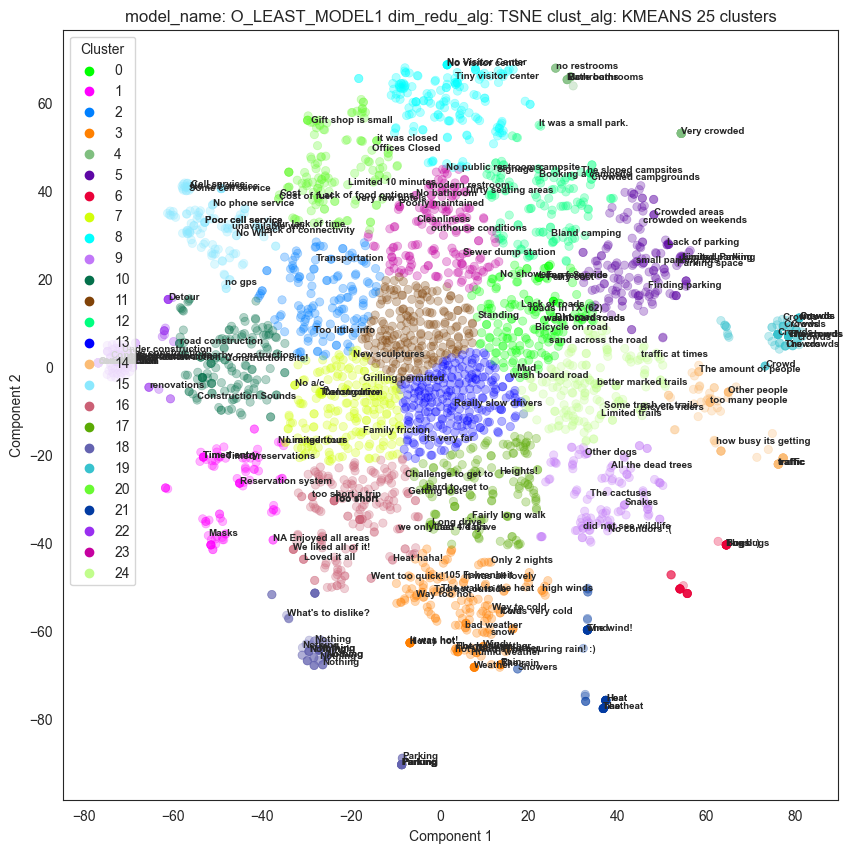

In [ ]:
#CLUST: KMEANS
o_least1_model1.clusterize(cluster_algorithm='kmeans', num_clusters=25)
o_least1_model1.generate_cluster_graph(figsize=(10,10), num_annotations = 200, jitter_amount=0.01, hide_labels=False, hide_legend=False)

## VAR2: o_like1

In [ ]:
# DIM_REDU: TSNE
o_like_model1 = NLP(data_clean['o_like1'].iloc[:], embedding_model=modelGN300, model_name='o_like_model1')
o_like_model1.dimension_reduce('tsne', perplexity=20)

Seeds have been reset to: 42
4990 total samples
Successfully Tokenized
Seeds have been reset to: 42
Reduced dimensions to 2 using TSNE


Seeds have been reset to: 42


Clustered using KMEANS
For n_clusters = 30
Silhouette coefficient: 0.44
Inertia: 631802.750
Seeds have been reset to: 42
Annotated 200 Sentences


<Figure size 1000x1000 with 0 Axes>

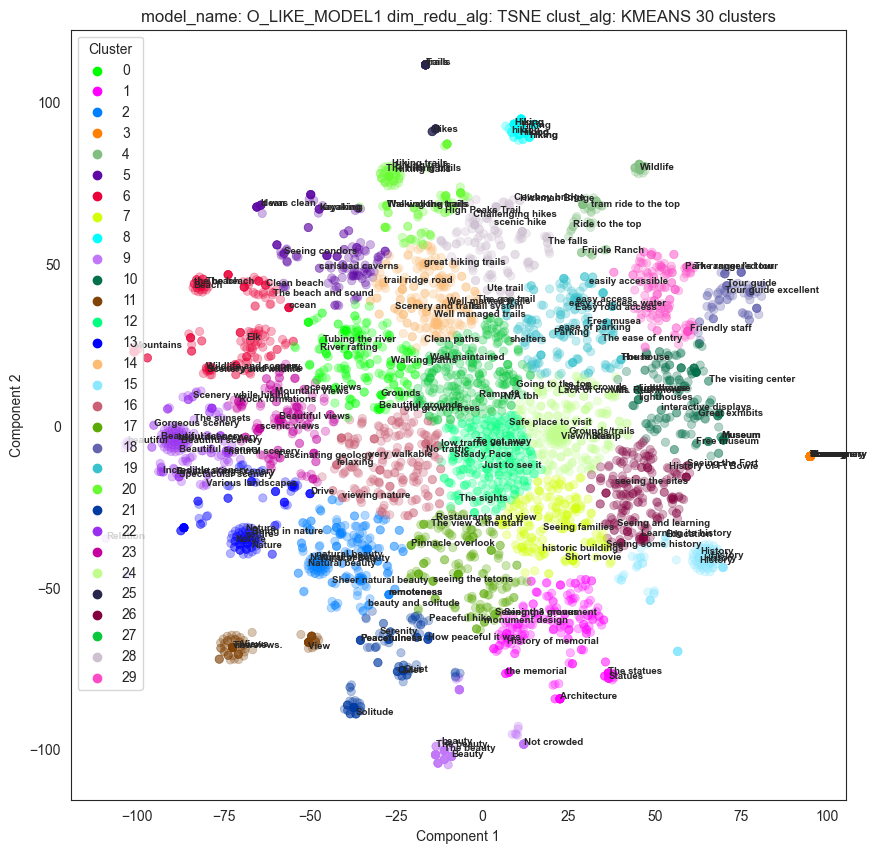

In [ ]:
#CLUST: KMEANS
o_like_model1.clusterize(cluster_algorithm='kmeans', num_clusters=30)
o_like_model1.generate_cluster_graph(figsize=(10,10), num_annotations = 200, jitter_amount=0.01, hide_labels=False, hide_legend=False)

## VAR3: o_subjects

In [ ]:
# DIM_REDU: TSNE
o_subjects_model1 = NLP(data_clean['o_subjects'].iloc[:], embedding_model=modelGN300, model_name='o_subjects_model1')
o_subjects_model1.dimension_reduce('tsne', perplexity=20)

Seeds have been reset to: 42
1560 total samples


Successfully Tokenized
Seeds have been reset to: 42
Reduced dimensions to 2 using TSNE


Seeds have been reset to: 42


Clustered using KMEANS
For n_clusters = 25
Silhouette coefficient: 0.40
Inertia: 78018.289
Seeds have been reset to: 42
Annotated 200 Sentences


<Figure size 1000x1000 with 0 Axes>

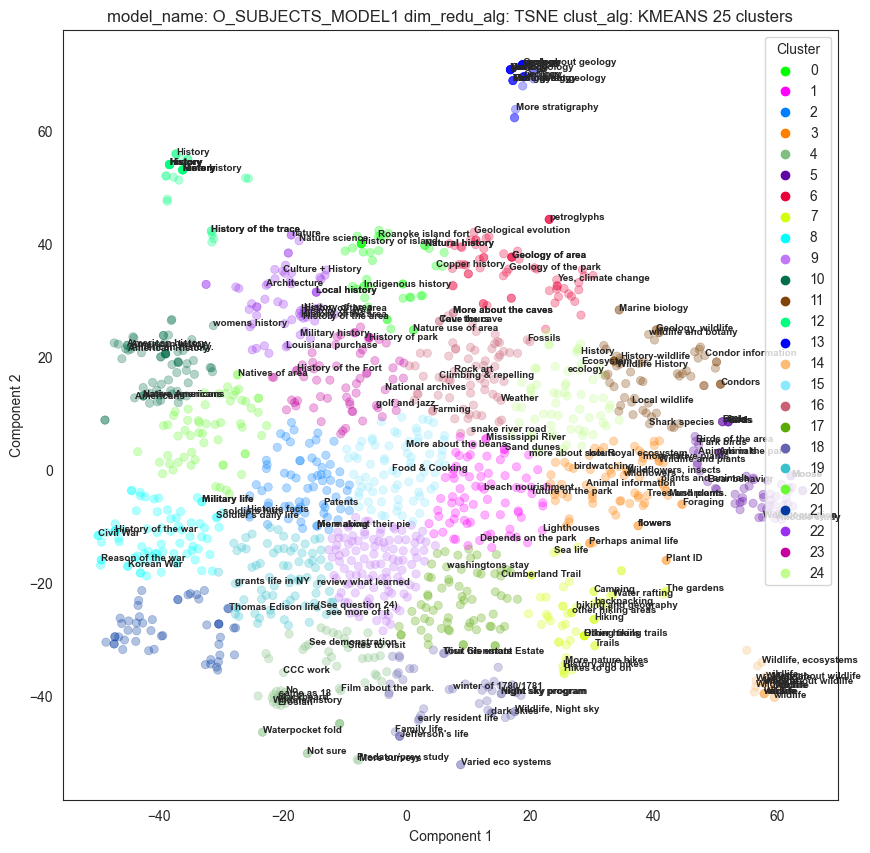

In [ ]:
#CLUST: KMEANS
o_subjects_model1.clusterize(cluster_algorithm='kmeans', num_clusters=25)
o_subjects_model1.generate_cluster_graph(figsize=(10,10), num_annotations = 200, max_char_length=20, jitter = False, jitter_amount=2, hide_labels=False, hide_legend=False)

In [ ]:
# DIM_REDU: TSNE
o_subjects_model2 = NLP(data_clean['o_subjects'].iloc[:], embedding_model=modelGN300, model_name='o_subjects_model2')
o_subjects_model2.dimension_reduce('spectral_emb', perplexity=20)

Seeds have been reset to: 42
1560 total samples


Successfully Tokenized
Seeds have been reset to: 42
Reduced dimensions to 2 using SPECTRAL_EMB


Seeds have been reset to: 42
Clustered using KMEANS
For n_clusters = 25
Silhouette coefficient: 0.41
Inertia: 0.000
Seeds have been reset to: 42
Annotated 200 Sentences


<Figure size 1000x1000 with 0 Axes>

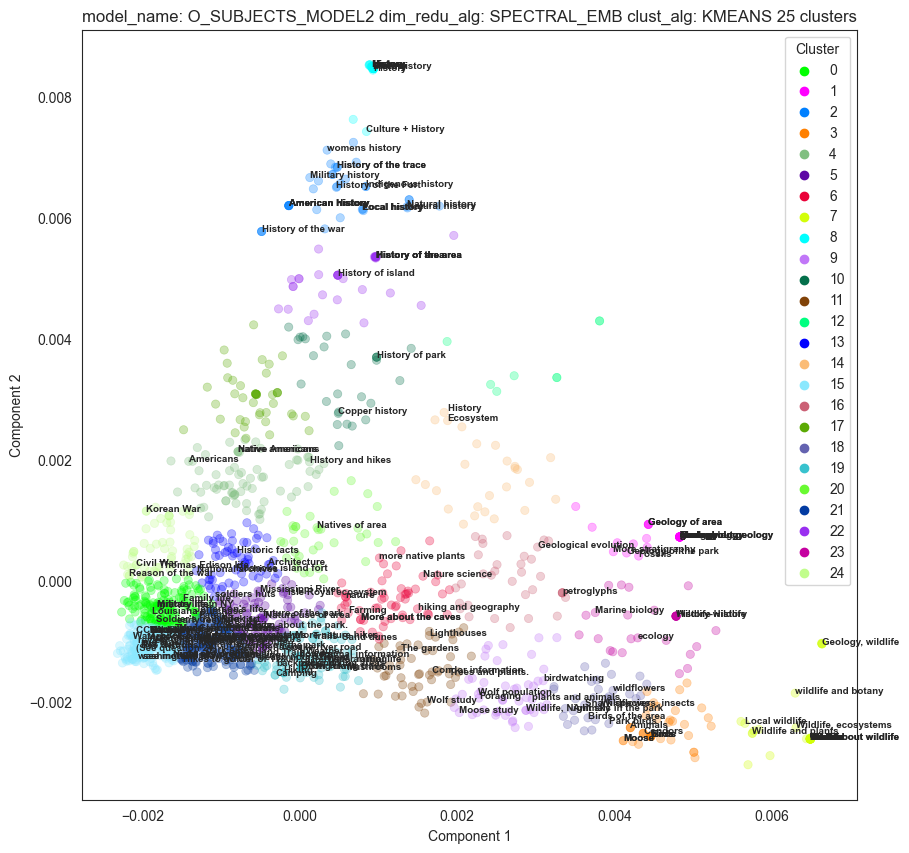

In [ ]:
#CLUST: KMEANS
o_subjects_model2.clusterize(cluster_algorithm='kmeans', num_clusters=25)
o_subjects_model2.generate_cluster_graph(figsize=(10,10), num_annotations = 200, max_char_length=20, jitter = False, jitter_amount=2, hide_labels=False, hide_legend=False)

## VAR4: o_addl

In [ ]:
# DIM_REDU: TSNE
o_addl_model1 = NLP(data_clean['o_addl'].iloc[:], embedding_model=modelGN300, model_name='o_addl_model1')
o_addl_model1.dimension_reduce('tsne', perplexity=50)

Seeds have been reset to: 42
2281 total samples


Successfully Tokenized
Seeds have been reset to: 42
Reduced dimensions to 2 using TSNE


Seeds have been reset to: 42


Clustered using KMEANS
For n_clusters = 25
Silhouette coefficient: 0.36
Inertia: 48175.184
Seeds have been reset to: 42
Annotated 200 Sentences


<Figure size 1000x1000 with 0 Axes>

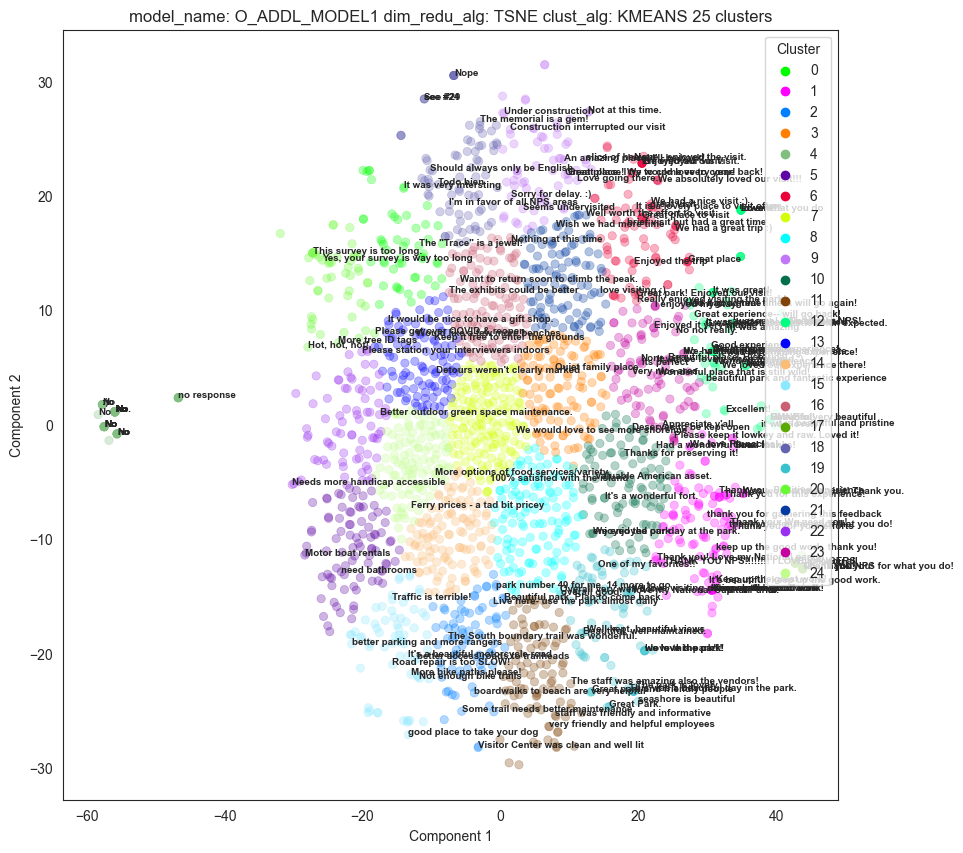

In [ ]:
#CLUST: KMEANS
o_addl_model1.clusterize(cluster_algorithm='kmeans', num_clusters=25)
o_addl_model1.generate_cluster_graph(figsize=(10,10), num_annotations = 200, max_char_length=40, jitter = False, jitter_amount=2, hide_labels=False, hide_legend=False)

In [ ]:
# DIM_REDU: TSNE
o_addl_model2 = NLP(data_clean['o_addl'].iloc[:], embedding_model=modelGN300, model_name='o_addl_model2')
o_addl_model2.dimension_reduce('spectral_emb', perplexity=50)

Seeds have been reset to: 42
2281 total samples


Successfully Tokenized
Seeds have been reset to: 42
Reduced dimensions to 2 using SPECTRAL_EMB


Seeds have been reset to: 42


Clustered using KMEANS
For n_clusters = 25
Silhouette coefficient: 0.37
Inertia: 0.000
Seeds have been reset to: 42
Annotated 200 Sentences


<Figure size 1000x1000 with 0 Axes>

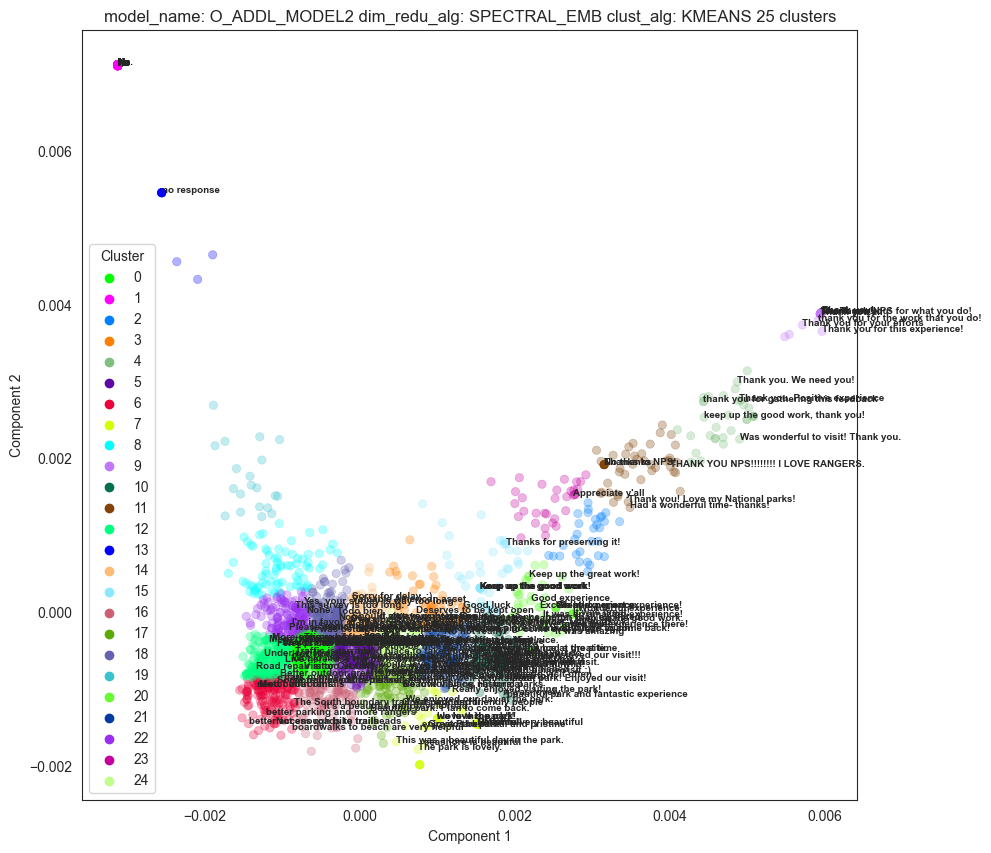

In [ ]:
#CLUST: KMEANS
o_addl_model2.clusterize(cluster_algorithm='kmeans', num_clusters=25)
o_addl_model2.generate_cluster_graph(figsize=(10,10), num_annotations = 200, max_char_length=40, jitter = False, jitter_amount=2, hide_labels=False, hide_legend=False)

In [ ]:
df_1 = o_addl_model1.get_cluster_info(4)
print(df_1.shape)
df_1

(86, 7)


component1  component2     sentance  orig_index  cluster  \
22    -55.898151    1.129889        No :)         149        4   
30    -55.898151    1.129889           No         202        4   
35    -46.702496    2.357806  no response         253        4   
38    -46.702496    2.357806  no response         270        4   
42    -46.702496    2.357806  no response         297        4   
...          ...         ...          ...         ...      ...   
2223  -57.454487   -0.173223           No       19507        4   
2230  -57.454487   -0.173223           No       19569        4   
2247  -57.717838    1.752908           no       19637        4   
2271  -57.717838    1.752908           No       19762        4   
2278  -57.454487   -0.173223           No       19821        4   

             colorCode  alpha  
22    (0.5, 0.75, 0.5)    0.3  
30    (0.5, 0.75, 0.5)    0.3  
35    (0.5, 0.75, 0.5)    0.3  
38    (0.5, 0.75, 0.5)    0.3  
42    (0.5, 0.75, 0.5)    0.3  
...                ...    ...  
2223  (0.5, 0.75, 0.5)    0.3  
2230  (0.5, 0.75, 0.5)    0.3  
2247  (0.5, 0.75, 0.5)    0.3  
2271  (0.5, 0.75, 0.5)    0.3  
2278  (0.5, 0.75, 0.5)    0.3  

[86 rows x 7 columns]

# Interesting Cluster Notes

cluster# (themes) #of_responses

### o_least1_model1
- 19 (crowds) 84
- 5 (limited parking / crowding) 159
- 14 (busy / traffic) 83
- 18 (nothing to dislike) 93
- 1 (covid measures / timed entry) 86
- 15 (lack of cell service / wifi)  119
- 6 (mosquitos / bugs) 40
- 16 (didn't have enough time / loved everything) 175

### o_like_model1
- 8 (hiking) 127
- 20 (hiking trails) 129
- 25 (hikes / trails) 52
- 13 (nature) 139
- 11 (views) 101
- 1 (memorials / architecture / statues) 212
- 18 (tours / guides) 82
- 21 (solitude / quietness) 134
- 10 (visitor centers / exhibits / videos / museums) 175
- 2 (natural beauty) 200
- 3 (scenery) 346

### o_subjects_model1
- 12 (history) 41
- 10 (american history / heritage) 66
- 8 ('war related information') 77
- 14 (wildlife) 29
- 13 (geology) 34

### o_addl_model1
- 17 (thank you!) 32
- 4 (no) 86
- 20 ('survey related') 51
- 1 ('positive feedback regarding survey work') 114
- 6 (enjoyed visit) 94
    

## Saving Data

### Models

In [114]:
# 
models_data = merge_model_data(models = [o_least1_model1, o_like_model1, o_subjects_model1, o_subjects_model2, o_addl_model1, o_addl_model2])
save_data(models_data, 'models_data')

Data Saved.


# FOR DOCUMENTATION PURPOSES

Seeds have been reset to: 42
1 total samples
Successfully Tokenized


<Axes: >

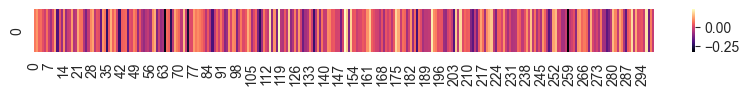

In [32]:
test_data = pd.Series(['I liked the visitor center'])
# test_data = pd.Series('liked visitor center'.split())
test = NLP(test_data, model=modelGN300)
test.tokenized_docs
vecs = pd.DataFrame(test.vectorized_docs)
plt.figure(figsize=(10, 5/9), dpi=100)
sns.heatmap(vecs[vecs.columns[:]], linewidth=0, cmap='magma')

Seeds have been reset to: 42
3 total samples
Successfully Tokenized


<Axes: >

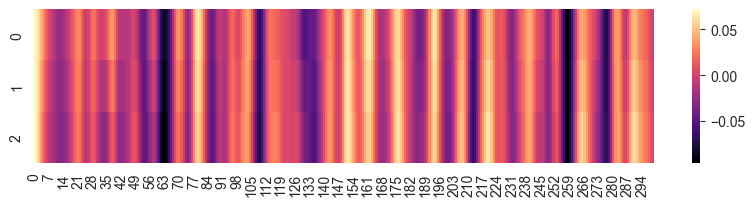

In [30]:
test_data = pd.Series('liked visitor center'.split())
test = NLP(test_data, model=modelGN300)
test.tokenized_docs
vecs = pd.DataFrame(test.vectorized_docs)
vecs = pd.DataFrame(gaussian_filter(vecs, sigma=2))
plt.figure(figsize=(10, 2), dpi=100)
sns.heatmap(vecs[vecs.columns[:]], linewidth=0, cmap='magma')

In [103]:
test = NLP(data_clean['o_least1'].iloc[:], embedding_model=modelGN300, model_name='test')
test.dimension_reduce('tsne', perplexity=20)

Seeds have been reset to: 42
3293 total samples
Successfully Tokenized
Seeds have been reset to: 42
Reduced dimensions to 2 using TSNE


<Axes: >

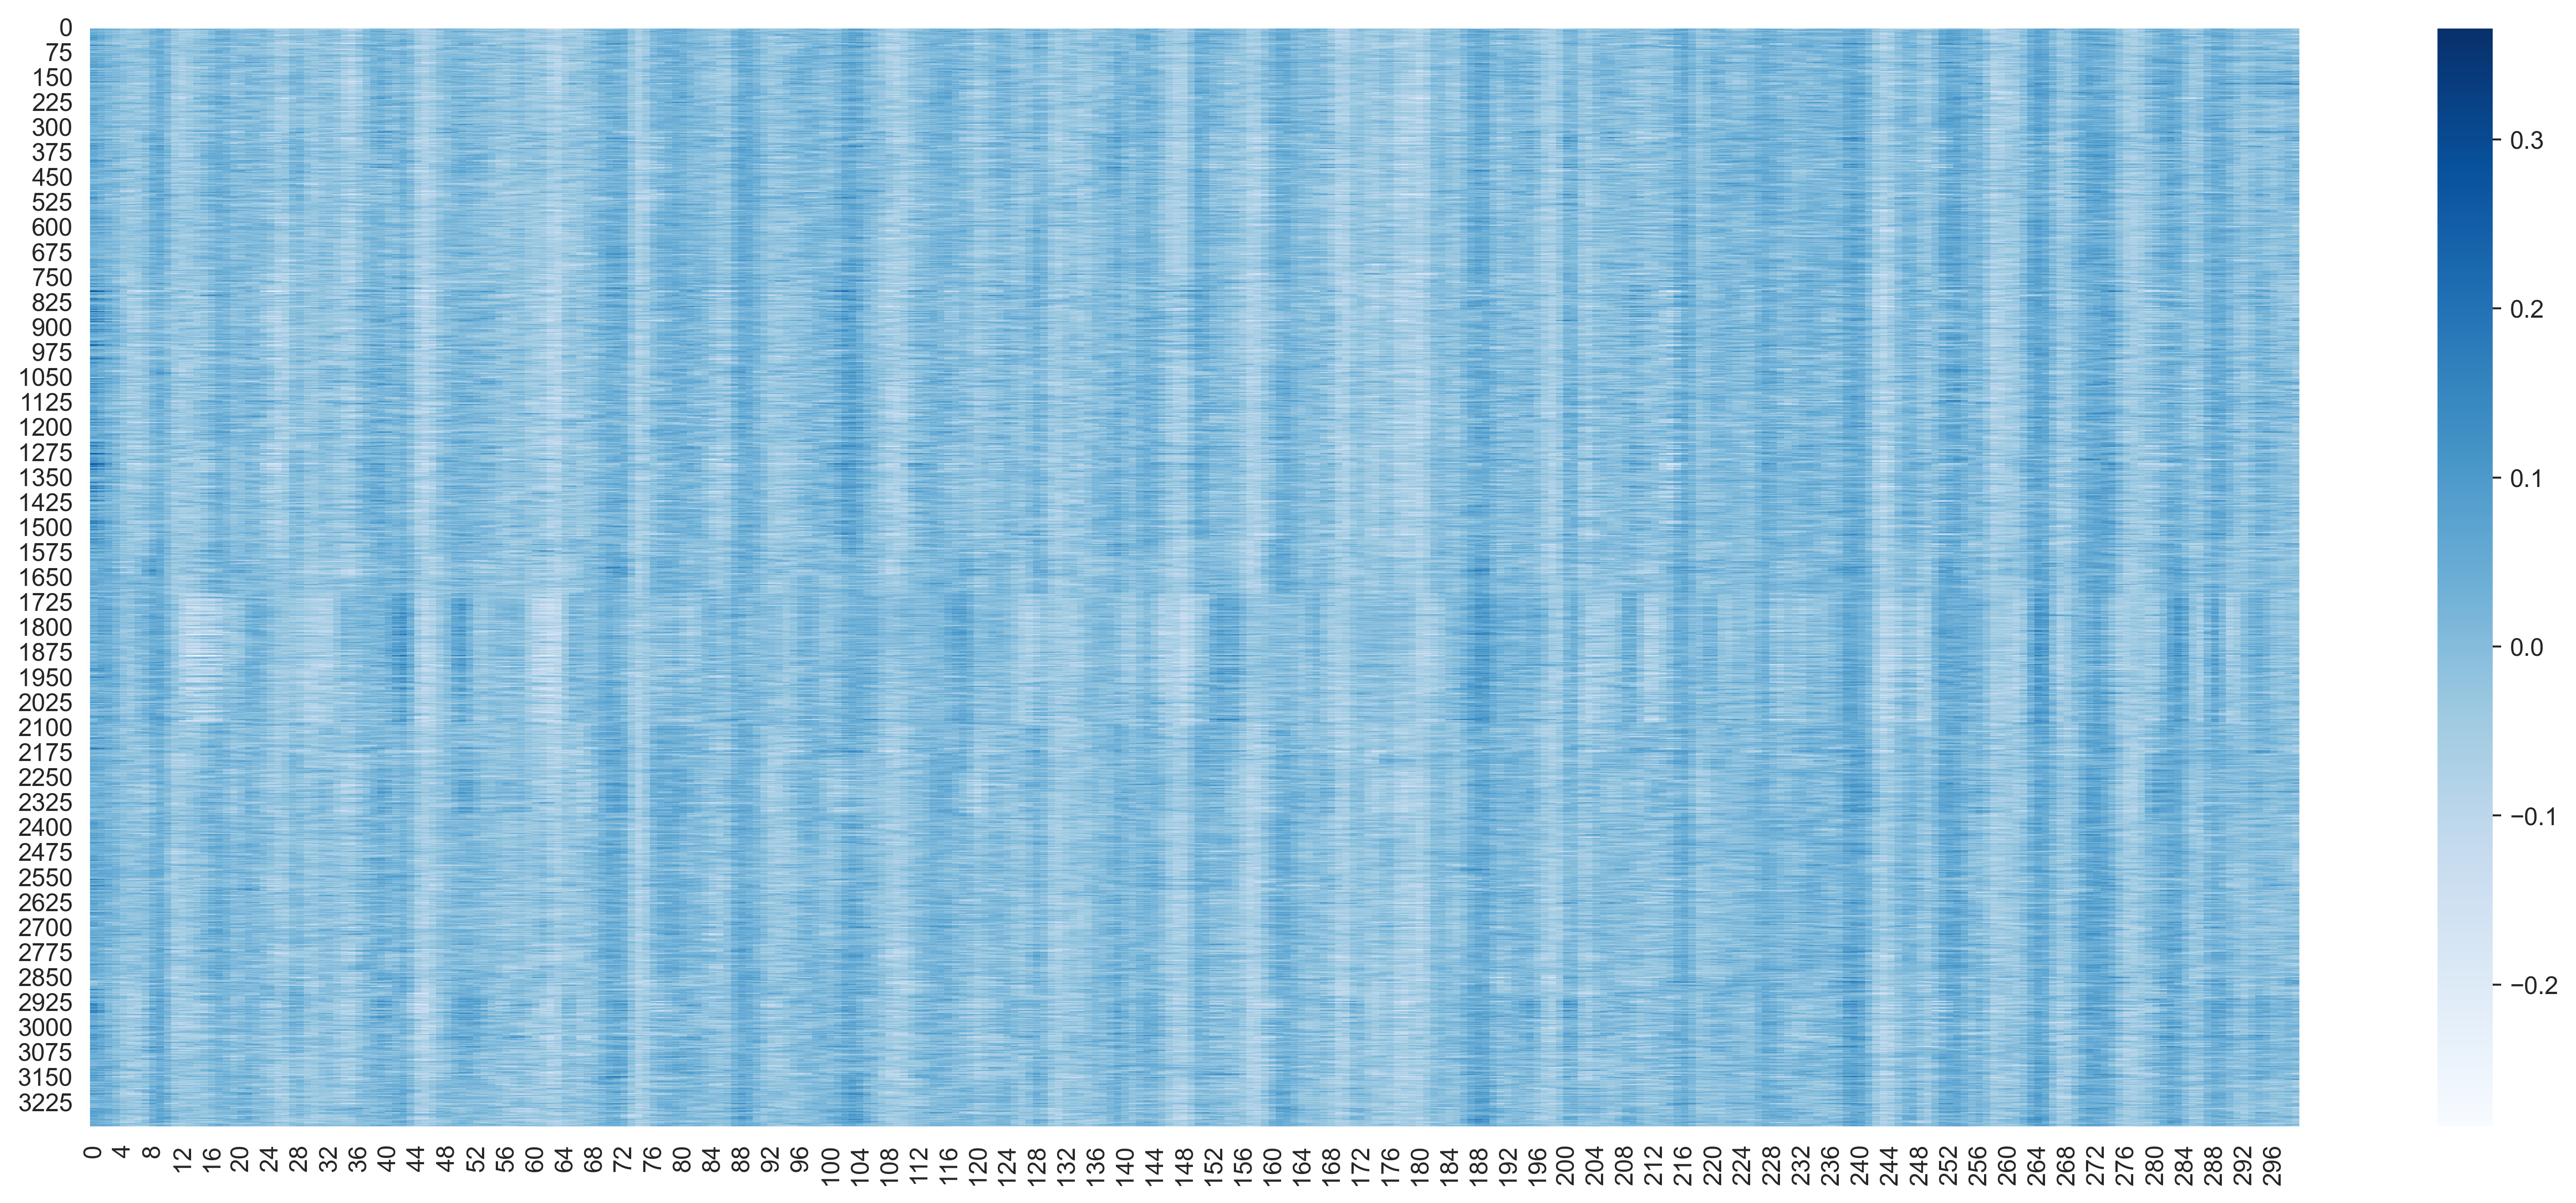

In [117]:
from scipy.ndimage.filters import gaussian_filter
vecs = pd.DataFrame(test.vectorized_docs)
vecs = pd.DataFrame(gaussian_filter(vecs, sigma=1))
plt.figure(figsize=(20, 8), dpi=400)
sns.heatmap(vecs.iloc[0:][:], linewidth=0, cmap='Blues')

In [25]:
data = pd.DataFrame(o_like_model1.vectorized_docs)
data = o_infoneed_model1.datapoints[['component1', 'component2']].iloc[0:10]

<Axes: >

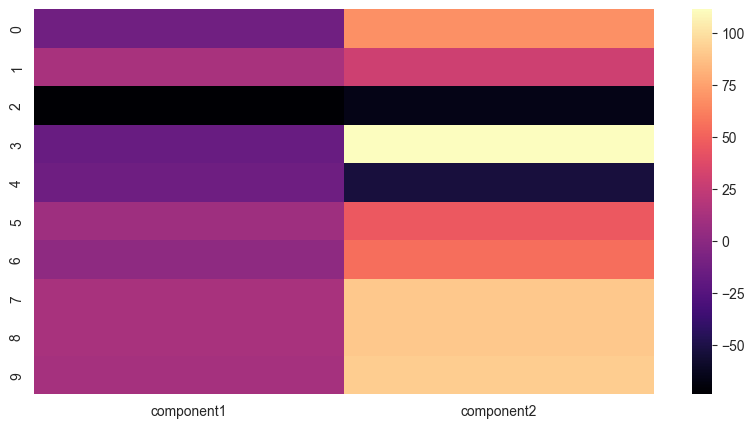

In [26]:
plt.figure(figsize=(10, 5), dpi=100)
sns.heatmap(data, linewidth=0, cmap='magma')

Seeds have been reset to: 42
Annotated 200 Sentences


<Figure size 600x600 with 0 Axes>

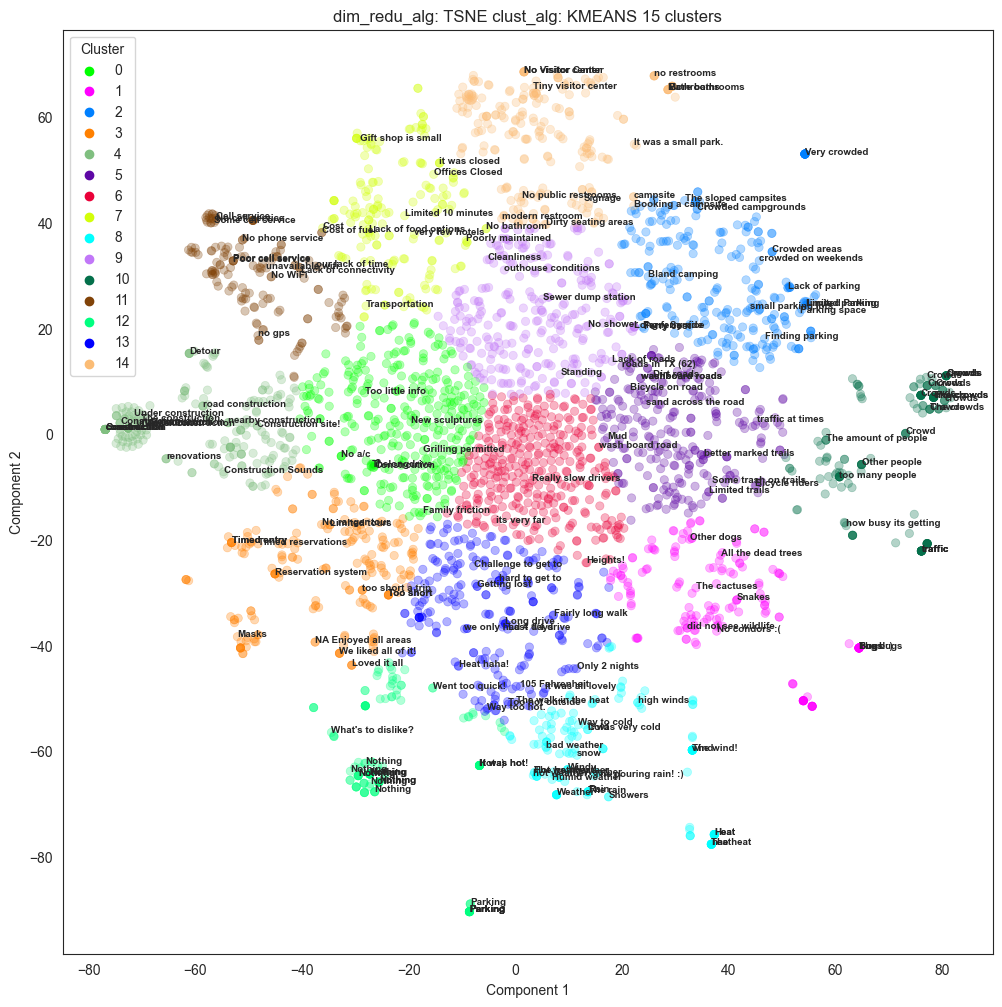

In [146]:
o_least1_model1.generate_cluster_graph(figsize=(6,6), num_annotations = 200, jitter_amount=0.01, hide_labels=True)